In [1]:
# app/model_training.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # For splitting LSTM data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler # For LSTM
import xgboost as xgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.pytorch # For LSTM (PyTorch)
import torch
import torch.nn as nn
import torch.utils.data 
import torch.optim as optim
import pickle
import os
from matplotlib import pyplot as plt



In [2]:
sp500_path = r'D:\H.U.S.T\Machine Learning\MLOps - Remastered\data\gspc_processed_data.csv'
df_trad_processed = pd.read_csv(sp500_path, index_col='Date', parse_dates=True)
INPUT_FEATURES = [f'{'Close'}_lag_{i}' for i in range(1, 14 + 1)] + \
                 [f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df_trad_processed['target_pct_change'] = (df_trad_processed['model_target'] - df_trad_processed['Close']) / df_trad_processed['Close']

In [3]:

X_trad = df_trad_processed[INPUT_FEATURES].copy()
y_trad = df_trad_processed['target_pct_change'].copy()
split_idx_trad = int(len(X_trad) * 0.8)
X_train_trad, X_test_trad = X_trad.iloc[:split_idx_trad], X_trad.iloc[split_idx_trad:]
y_train_trad, y_test_trad = y_trad.iloc[:split_idx_trad], y_trad.iloc[split_idx_trad:]


In [4]:
best_rf_params = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 250}
rf_model = RandomForestRegressor(**best_rf_params, random_state=42, n_jobs=-1)
rf_model.fit(X_train_trad, y_train_trad)
y_pred_pct_rf = rf_model.predict(X_test_trad)

In [5]:
last_actual_close_for_test_samples = df_trad_processed.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df_trad_processed.loc[X_test_trad.index, 'model_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred_pct_rf)


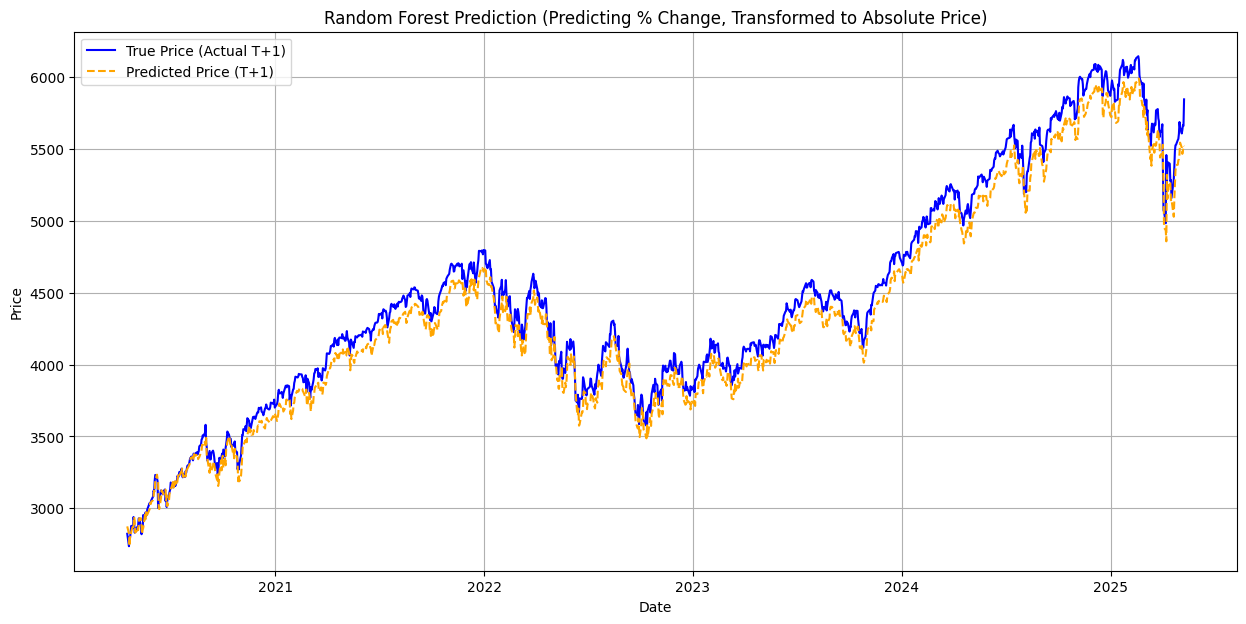

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(y_test_absolute_actual.index, y_test_absolute_actual, label='True Price (Actual T+1)', color='blue')
plt.plot(y_test_absolute_actual.index, y_pred_absolute_test, label='Predicted Price (T+1)', color='orange', linestyle='--')
plt.title('Random Forest Prediction (Predicting % Change, Transformed to Absolute Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()